In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)

In [9]:
X_train = pd.read_csv("../data/training/X_train.csv")
X_test = pd.read_csv("../data/training/X_test.csv")
y_train = pd.read_csv("../data/training/y_train.csv")
y_test = pd.read_csv("../data/training/y_test.csv")

In [10]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

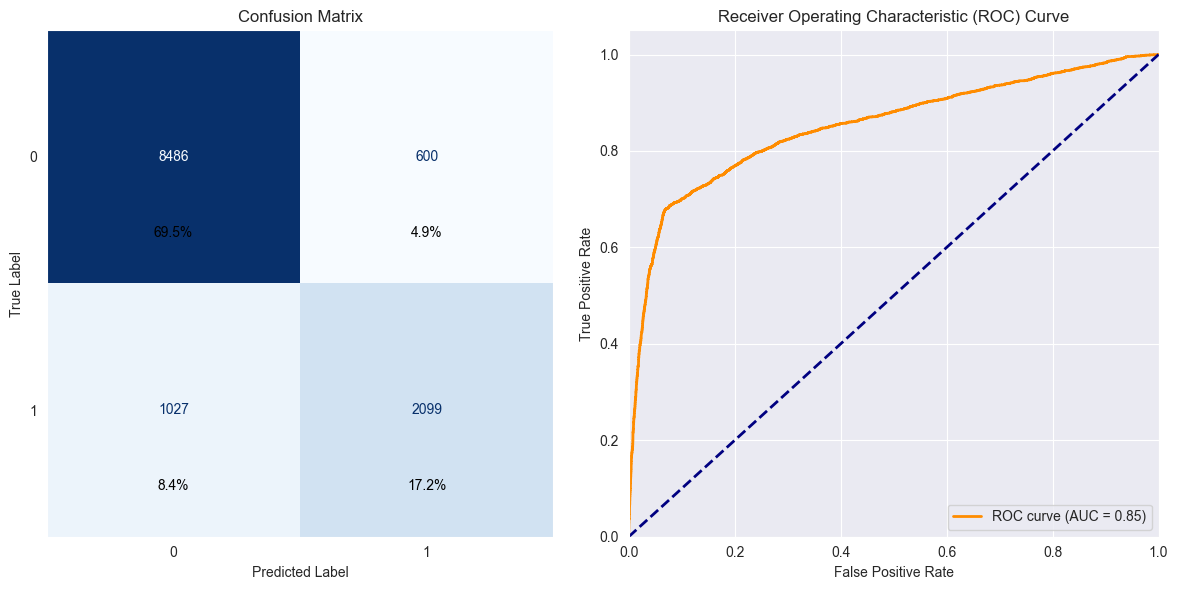

In [14]:
# Initialize the logistic regression model
model = LogisticRegression(solver='liblinear')  # 'liblinear' is good for small datasets

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict probabilities (for ROC curve)
y_probs = model.predict_proba(X_test)[:, 1]

# Predict labels (for confusion matrix)
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.grid(False)

cm_percent = cm / cm.sum() * 100  # Divide each cell by the total sum of the matrix to get percentages

# Annotate with percentages below the numbers
for i in range(cm.shape[0]):  # Iterate over rows
    for j in range(cm.shape[1]):  # Iterate over columns
        percentage = f"{cm_percent[i, j]:.1f}%"  # Format percentage
        ax1.text(j, i + 0.3, percentage, ha="center", va="center", fontsize=10, color="black")  # Add below numbers

# Plot ROC curve
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
ax2.legend(loc='lower right')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()